In [2]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.applications import VGG16
from keras import regularizers

import os

batch_size = 32
num_classes = 10
max_epochs = 20
input_shape = (150, 150, 3)
weight_decay = 0.0005


save_dir = '/home/ec2-user/Telecom/experiments/saved_models'
model_name = 'keras_vgg16_imagenette_trained_model.h5'
model_path = os.path.join(save_dir, model_name)
train_path = '/home/ec2-user/Telecom/experiments/data/imagenette2-320/train'
test_path = '/home/ec2-user/Telecom/experiments/data/imagenette2-320/val'

# The data, split between train and test sets:
train_datagen = ImageDataGenerator(
        rescale=1./255,    
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')


baseModel = VGG16(weights="imagenet",
                include_top=False,
                input_tensor=Input(shape=(150, 150, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(num_classes, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
learning_rate = 1e-4

sgd = keras.optimizers.SGD(lr=learning_rate, momentum=0.9, nesterov=True)


early_stop = keras.callbacks.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                     min_delta=0, 
                                                     patience=4, 
                                                     verbose=0, 
                                                     mode='auto', 
                                                     baseline=None, 
                                                     restore_best_weights=False)


# Let's train the model using sgd
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

model_checkpoint = ModelCheckpoint(model_path, monitor='loss', verbose=1, save_best_only=True)


model.fit_generator(
          train_generator,
          epochs=max_epochs,
          validation_data=validation_generator,
          steps_per_epoch = 300,
          validation_steps = 150,
          verbose = 1,
          callbacks=[model_checkpoint, early_stop]
)

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.
Epoch 1/20
300/300 [==============================] - 72s 240ms/step - loss: 1.9482 - accuracy: 0.3320 - val_loss: 1.2919 - val_accuracy: 0.6642

Epoch 00001: loss improved from inf to 1.94811, saving model to /home/ec2-user/Telecom/experiments/saved_models/keras_vgg16_imagenette_trained_model.h5
Epoch 2/20
300/300 [==============================] - 67s 223ms/step - loss: 1.4051 - accuracy: 0.5473 - val_loss: 0.9587 - val_accuracy: 0.7271

Epoch 00002: loss improved from 1.94811 to 1.40516, saving model to /home/ec2-user/Telecom/experiments/saved_models/keras_vgg16_imagenette_trained_model.h5
Epoch 3/20
300/300 [==============================] - 67s 224ms/step - loss: 1.1813 - accuracy: 0.6239 - val_loss: 0.8921 - val_accuracy: 0.7590

Epoch 00003: loss improved from 1.40516 to 1.18136, saving model to /home/ec2-user/Telecom/experiments/saved_models/keras_vgg16_imagenette_trained_model.h5
Epoch 4/20
3

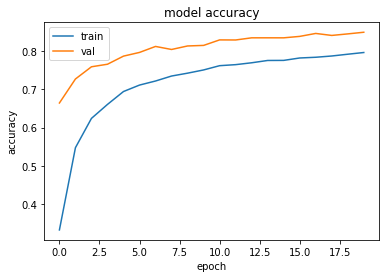

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()